Логистическая регрессия

И в линейной и в логистической регрессии используется линейная функция. Только в линейной регрессии она используется для предсказания значений, а в логистической - для предсказания отнесения к одному из двух классов (0 или 1, да или нет, и т.д.)

Классы разделяются поверхностью, в зависимости от кол-ва фичей это может быть линия, плоскость или гиперплоскость (многомерная плоскость)

Чем дальше значения лежат от разделяющей поверхности, тем уверенее модель относит объект к тому или иному классу. Но по абсолютным значениям нельзя сказать, насколько мы далеко от некой точки. Поэтому абсолютные числа надо перевести в относительные. Сделать это можно прогоняя числа через функцию сигмоиды. В результате получим числа в диапазоне от 0 до 1.

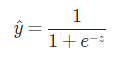

z - ответы линейной функции

Чем больше значение логита, тем дальше оно будет от разделяющей линии и тем ближе значение будет к 1 после применения функции сигмоиды (т.е. тем выше уверенность). Отрицательные значения будут меньше 0.5 – это значит, что они принадлежат другому классу. Чем ближе логиты к разделяющей плоскости, тем ближе будут значение к 0.5 после применения сигмоиды – т.е. модель меньше будет уверена в ответе.


В некоторых библиотеках машинного обучения значения, полученные после сигмоиды, называются predict_proba.

LogLoss

LogLoss - функция потерь логистической регрессии

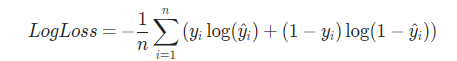

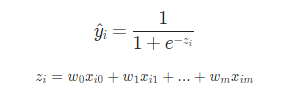

Выражая в матричном виде, получим

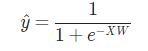

Градиент по функции потерь:

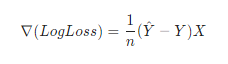

Переходим к практике

In [109]:
import numpy as np
import pandas as pd
import random
import math
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn.metrics as skm
from sklearn.metrics import  roc_curve

X, y = make_classification(n_samples=1000, n_features=14, n_informative=10, random_state=42)
X = pd.DataFrame(X)
y = pd.Series(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [110]:
class MyLogReg():
    def __init__(self, n_iter=10, learning_rate=0.1, weights=None, metric=None):
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.weights = weights
        self.metric = metric #accuracy, precision, recall, f1, roc_auc

    
    
    def fit(self, X, y, verbose=False):
        X = X.copy()
        y = y.copy()
        X.insert(0, "bias", 1)
        if self.weights is None:    
            self.weights = np.ones(X.shape[1])

        error_hist = []

        for epoch in range(self.n_iter):
            y_pred = 1 / (1 + np.exp(-X @ self.weights))
            self.weights -= self.learning_rate * self.get_grad(X, y, y_pred)

            log_loss = self.get_log_loss(y, y_pred)
            error_hist.append(log_loss)

            if verbose and (epoch == 1) | (epoch % verbose == 0):
                if self.metric:
                    print(f'{epoch}| LogLoss: {np.round(log_loss, 2)} | {self.metric}: {self.get_score(X, y)}')    
                else:
                    print(f'{epoch}| LogLoss: {np.round(log_loss, 2)}')    
        return error_hist  
    
    def sigmoid(self, y_pred):
        return 1 / (1 + np.exp(-y_pred))
    
    def get_score(self, X, y):
        if self.metric in ('accuracy', 'precision', 'recall', 'f1'):
            # score = getattr(self, 'get_' + self.metric)(y, np.where(self.sigmoid(X @ self.weights) > 0.5, 1, 0))
            return getattr(self, 'get_' + self.metric)(y, np.where(self.sigmoid(X @ self.weights) > 0.5, 1, 0))
        elif self.metric == "roc_auc":
            return getattr(self, 'get_' + self.metric)(y, self.sigmoid(X @ self.weights))
        else:
            raise ValueError("Invalid metric. Supported: accuracy, precision, recall, f1, roc_auc")
            
    
    def get_accuracy(self, y, y_pred):
        confusion_matrix = self.get_confusion_matrix(y, y_pred)
        return (confusion_matrix[0, 0] + confusion_matrix[1, 1]) / np.sum(confusion_matrix)
    
    def get_precision(self, y, y_pred):
        confusion_matrix = self.get_confusion_matrix(y, y_pred)
        return confusion_matrix[1, 1] / (confusion_matrix[0, 1] + confusion_matrix[1, 1])
    
    def get_recall(self, y, y_pred):
        confusion_matrix = self.get_confusion_matrix(y, y_pred)
        return confusion_matrix[1, 1] / (confusion_matrix[1, 1] + confusion_matrix[1, 0])
    
    def get_f1(self, y, y_pred):
        precision = self.get_precision(y, y_pred)
        recall = self.get_recall(y, y_pred)
        return 2 * precision * recall / (precision + recall)    
    
    def get_roc_auc(self, y, y_pred):
        df = pd.DataFrame({'predicted': y_pred, 'ground_truth': y}).sort_values(by = 'predicted', ascending=False)
        p = df[df['ground_truth'] == 1]
        n = df[df['ground_truth'] == 0]
    
        total = 0
        for prob in n['predicted']:
            positive_score = (p['predicted'] > prob).sum()
            same_score = (p['predicted'] == prob).sum()
            total += positive_score + 0.5 * same_score
        
        return (1 / (p.shape[0] * n.shape[0]) * total)
        
    def get_confusion_matrix(self, y, y_pred):
        """
        TN FP
        FN TP
        """
        classes = np.unique(y) #классы
        confusion_matrix = np.zeros((len(classes), len(classes)))

        for i in range(len(classes)):
            for j in range(len(classes)):
                confusion_matrix[i, j] = np.sum((y == classes[i]) & y_pred == classes[j])
        return confusion_matrix

    def get_grad(self, X, y, y_pred):
        return ((y_pred - y) @ X) / len(y_pred)

    def get_log_loss(self, y, y_pred):
        return -np.mean((y * np.log(y_pred + 1e-15)) + (1 - y) * np.log(1 - y_pred + 1e-15))
    
    def predict_proba(self, X):
        X = X.copy()
        X.insert(0, "bias", 1)
        return 1 / (1 + np.exp(-X @ self.weights))
    
    def predict(self, X):
        X = X.copy()
        X.insert(0, "bias", 1)
        return np.where((1 / (1 + np.exp(-X @ self.weights))) > 0.5, 1, 0)
    
    def get_coef(self):
        return self.weights[1:]
    
    def __str__(self) -> str:
        return f"{self.__class__.__name__} class: " + ", ".join("%s=%s" % item for item in vars(self).items())
    
    def __repr__(self) -> str:
        return f"{self.__class__.__name__} class: " + ", ".join("%s=%s" % item for item in vars(self).items())
    
   

0| LogLoss: 3.83 | roc_auc: 0.5251693792344808
1| LogLoss: 3.53 | roc_auc: 0.5330445761144028


100| LogLoss: 0.42 | roc_auc: 0.9057538938473462
200| LogLoss: 0.37 | roc_auc: 0.9166104152603815


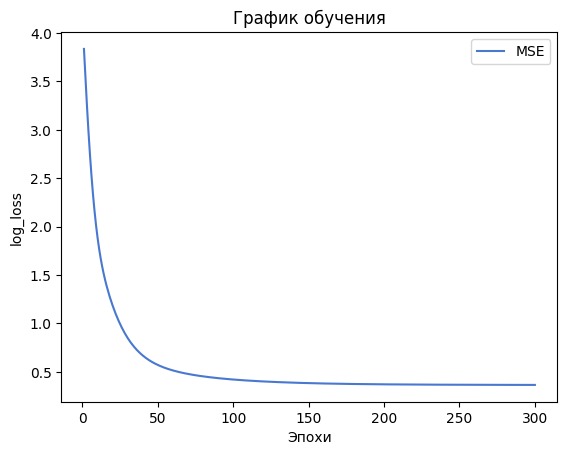

In [111]:
logreg = MyLogReg(n_iter=300, learning_rate=0.1, metric='roc_auc')
history = logreg.fit(X_train, y_train, 100)

epochs = range(1, len(history) + 1)

plt.plot(epochs, history, 'b', label='MSE')
plt.title('График обучения')
plt.xlabel('Эпохи')
plt.ylabel('log_loss')
plt.legend()

# Отобразите график.
plt.show()

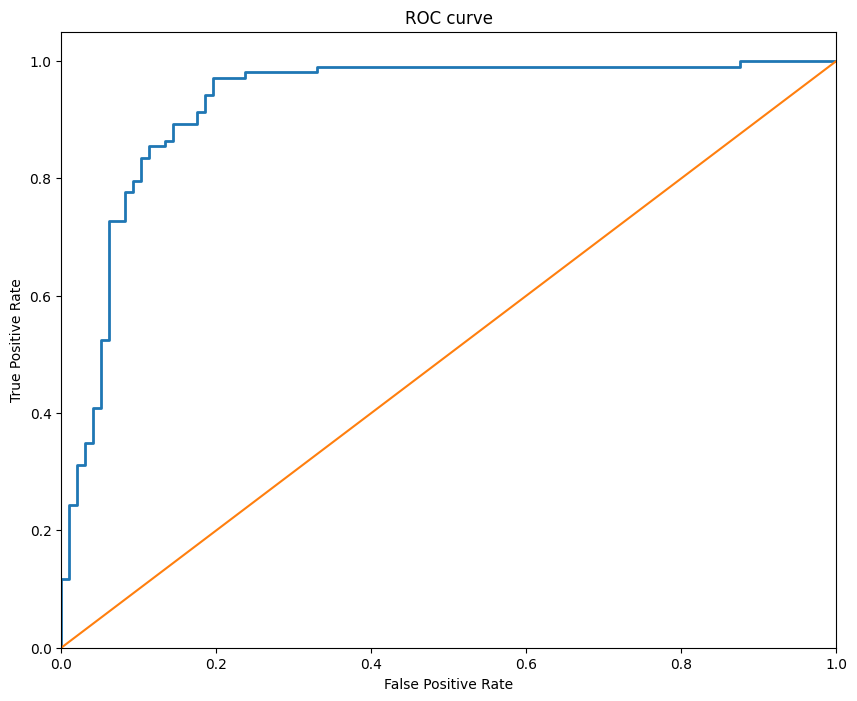

In [112]:
import seaborn as sns
sns.set_color_codes("muted")


plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test), pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [113]:
pred = logreg.predict(X_test)
print('accuracy: ', (pred == y_test).sum() / len(y_test))

accuracy:  0.865


In [114]:
metric_dict = {'roc_auc': skm.roc_auc_score(y_test, logreg.predict_proba(X_test)),
                'precision': skm.precision_score(y_test, pred),
                'recall': skm.recall_score(y_test, pred),
                'f1': skm.f1_score(y_test, pred)}
for k, v in metric_dict.items():
    print(f"{k}: {v}")

roc_auc: 0.9290361325192674
precision: 0.8725490196078431
recall: 0.8640776699029126
f1: 0.8682926829268293


In [116]:
X_test = X_test.copy()
X_test.insert(0, 'bias', 1)
logreg.get_score(X_test, y_test)

0.9290361325192673

[[188.  12.]
 [109.  91.]]

In [57]:
sorted(logreg.predict_proba(X_test))

[0.00021879120512343568,
 0.0016982325807804028,
 0.003103095091486597,
 0.0032283161287038043,
 0.004528723740526869,
 0.005053319003167059,
 0.005173762204509116,
 0.005521284991045498,
 0.006416809352478217,
 0.008501856872363326,
 0.009496719857232412,
 0.009896980221940792,
 0.01007740474682395,
 0.012554752208532334,
 0.013971701149996015,
 0.014930274242687936,
 0.01671079648271315,
 0.017811493931495597,
 0.019071982051415057,
 0.01960750617000661,
 0.01972565504885297,
 0.019998679177518432,
 0.020833888200125897,
 0.021142058625164523,
 0.02241995606696919,
 0.02722431271815208,
 0.03168739501661413,
 0.03403835780809122,
 0.036372807937796015,
 0.03696704566175153,
 0.03815349314863032,
 0.04053326206674463,
 0.04073660373796823,
 0.04213549871375962,
 0.04241277966155789,
 0.04297332227690677,
 0.044704964403802686,
 0.0530217278105536,
 0.05796851027145722,
 0.05863639108579343,
 0.06035463218706719,
 0.0693187469726497,
 0.07621614933208147,
 0.0830926199887112,
 0.083694

In [58]:
df = pd.DataFrame(logreg.predict_proba(X_test))
pred = logreg.predict(X_test)
df['pred'] = pred
df

,0,pred
521,0.294239,0
737,0.060355,0
740,0.996452,1
660,0.126668,0
411,0.991437,1
...,...,...
408,0.150082,0
332,0.728053,1
208,0.009497,0
613,0.945092,1
